In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import pickle
import torch.nn as nn
from scipy.stats import zscore
from nice.algorithms.connectivity_AT import *
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import gaussian_filter1d


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [4]:
def smooth_with_gaussian(data, sigma=2):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

def preprocess(data):
    #data shape: (trials, time, neurons)
    trials, time, num_neurons = data.shape
    z = np.zeros_like(data)

    for neuron in range(num_neurons):
        for t in range(time):
            vals = data[:, t, neuron]  #this is all the data for given neuron at given time point
            std = np.std(vals)
            if std > 1e-6:
                z[:, t, neuron] = (vals - np.mean(vals)) / std    #zscore if there is a stdev
            else:
                z[:, t, neuron] = np.median(vals)   #returnt the median value otherwise  (median rather than mean in case of large variability in a singel point)

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))
  
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]  #for class of input
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted == 0)[0]
    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]
    #shapes 1057, 500, 160/80)
 
    left_sm = smooth_with_gaussian(left_input_SP) 
    right_sm = smooth_with_gaussian(right_input_SP) 
    att_sm = smooth_with_gaussian(attention_SP) 
 
    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80
    
    # for j in range(0, num_trials):
    #     for i in range(0, num_neurons):
    #         count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
    #         if count_left > 0:
    #             left_sm[j, :, i] /= count_left
    #         count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
    #         if count_right > 0:
    #             right_sm[j, :, i] /= count_right


    #     for i in range(0, num_neurons_attention):
    #         count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
    #         if count_attention > 0:
    #             att_sm[j, :, i] /= count_attention

    #preprocess here now that we have traces of all of the relavant trials
    left_input_SP = preprocess(left_input_SP)[:, 100:350, :]
    right_input_SP = preprocess(right_input_SP)[:, 100:350, :]
    attention_SP = preprocess(attention_SP)[:, 100:350, :]

      #add in here at some point left != right and see if it makes a difference
    left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left
    print("left_indices_agg", left_indices_agg[0:20])
    print("relevent", relevant[0:20])
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
    print("left indices  ", left_indices[0:20])
    
    right_indices_agg = np.where((omitted == 0) & (attend_01 == 1) & (label_left != label_right))[0]
    print("right_indices_agg", right_indices_agg[0:20])
    print("relevent", relevant[0:20])
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)
    print("right indices  ", right_indices[0:20])


    left_attleft = left_input_SP[left_indices]
    left_attright = right_input_SP[left_indices]
    right_attleft = left_input_SP[right_indices]
    right_attright = right_input_SP[right_indices]
    att_attleft = attention_SP[left_indices]
    att_attright = attention_SP[right_indices]

    num_trials_left = len(left_indices)
    num_trials_right = len(right_indices)

    return left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, num_trials_left, num_trials_right
##e.g. dataset 1 gives left_attleft of shape (469 trials, 500 time points, 160 spikes)

l_al = []
l_ar = []
r_al = []
r_ar = []
a_al = []
a_ar = []

def collect_data(file_numbers):
    for file_number in file_numbers:
        left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, _, _, = get_data(file_number)
        l_al.append(left_attleft)
        l_ar.append(left_attright)
        r_al.append(right_attleft)
        r_ar.append(right_attright)
        a_al.append(att_attleft)
        a_ar.append(att_attright)
       
    return l_al, l_ar, r_al, r_ar, a_al, a_ar
   

In [5]:
#file_numbers = [1, 2, 4, 8, 14, 15, 20, 23] #for the full dataset
l_al, _, r_al, _, a_al, _ = collect_data(file_numbers = [1])

left_indices_agg [ 0  1  4 16 23 24 25 27 28 29 32 35 38 52 57 59 60 61 65 67]
relevent [ 0  1  4  6 11 14 16 19 21 23 24 25 27 28 29 31 32 35 37 38]
left indices   [ 0  1  2  6  9 10 11 12 13 14 16 17 19 24 27 29 30 31 34 35]
right_indices_agg [ 6 11 14 19 31 37 41 47 51 54 56 58 64 68 76 78 82 83 85 90]
relevent [ 0  1  4  6 11 14 16 19 21 23 24 25 27 28 29 31 32 35 37 38]
right indices   [ 3  4  5  7 15 18 20 21 23 25 26 28 33 36 38 39 41 42 43 46]


In [ ]:
print('# files = ', len(l_al))
print(l_al[0].shape)
print(l_al[1].shape)

print('# files = ', len(l_ar))
print(r_al[0].shape)
print(r_al[1].shape)

l_al_all = np.concatenate(l_al, axis=0)
r_al_all = np.concatenate(l_ar, axis=0)
a_al_all = np.concatenate(a_al, axis=0)

plt.plot(l_al_all[0, :, 0], label='left_attleft')
plt.plot(r_al_all[0, :, 0], label='left_attright')
plt.plot(a_al_all[0, :, 0], label='att_attleft')
plt.xlabel('Time (ms)')
plt.ylabel('Smoothed and z-scored activity')
plt.legend()
plt.title('Example neuron')
plt.show()

print('l_al_all shape = ', l_al_all.shape)
print('l_ar_all shape = ', r_al_all.shape)
print('a_al_all shape = ', a_al_all.shape)

plt.plot(l_al_all[0, :, :].mean(axis = 1), label='left_attleft')
plt.plot(r_al_all[0, :, :].mean(axis = 1), label='right_attleft')   
plt.plot(a_al_all[0, :, :].mean(axis = 1), label='att_attleft')
plt.xlabel('Time (ms)')
plt.ylabel('Smoothed and z-scored activity')
plt.legend()
plt.title('Example neuron')
plt.show()

want to now make this into the appropriate input vector for MVPA
x will have n_total_trial inputs, each vector will have one of the 80 or 160 neurons as basis vector, and values of those vectors at each time point, e.g. 500 vectors each of length (80, 1) 

the goal will be to train 4 models
left input x predicting attention y when attention is left
right input x when predicting attention y when attention is right
"" same but for attention right

can then compare the r^2, mean square error, model weights, feature importance etc

will need [trials, n_features]

will be good to just shuffle the data and analyse the null distribution

In [6]:
l_al_all = np.concatenate(l_al, axis=0)
a_al_all = np.concatenate(a_al, axis=0)
print('l_al_all shape:', l_al_all.shape)
print('a_al_all shape:', a_al_all.shape)

x = torch.tensor(l_al_all, dtype=torch.float32)  #l_al shape (n_trials, n_time, n_neurons)
y = torch.tensor(a_al_all, dtype=torch.float32)  #a_al shape (n_trials, n_time, n_neurons)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

train_datast = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_datast, batch_size=16, shuffle=True, drop_last = True, num_workers=0)


l_al_all shape: (468, 250, 160)
a_al_all shape: (468, 250, 80)


In [7]:
class SpikingAttentionLSTM(nn.Module):
    def __init__(self, input_dim = 160, hidden_dim = 128, output_dim = 80, num_layers = 2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim, 
            batch_first = True,
            num_layers = num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x) #shape (batch_size, 500, hidden_dim)
        out = self.fc(output)
        return out   #this will be shape (batch_size, 500, 80)
    
class SpikingAttentionSkipConnection(nn.Module):
    def __init__(self, input_dim=160, hidden_dim=128, output_dim=80, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim + input_dim, output_dim)  # skip connection

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # shape: (B, T, H)
        concat = torch.cat([lstm_out, x], dim=-1)  # skip connection
        return self.fc(concat)



In [8]:
def correlation_loss(pred, target):
    vx = pred - pred.mean(dim=1, keepdim=True)
    vy = target - target.mean(dim=1, keepdim=True)
    corr = (vx * vy).mean(dim=1) / (vx.std(dim=1) * vy.std(dim=1) + 1e-6)
    return 1 - corr.mean()

#or could try loss = 0.7 * criterion(y_pred, y_batch) + 0.3 * correlation_loss(y_pred, y_batch)



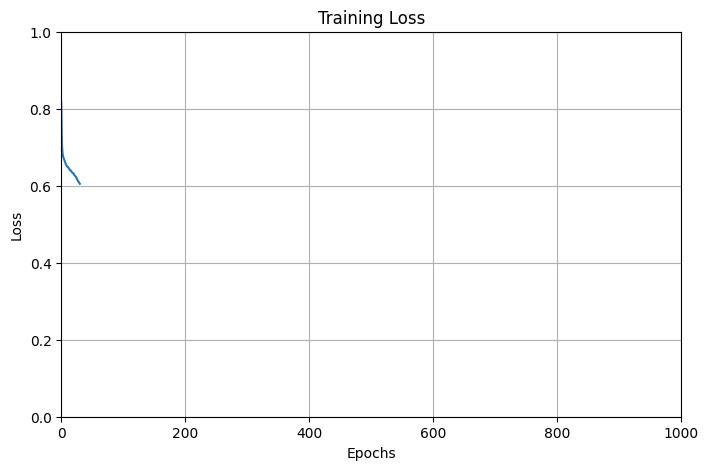

In [ ]:
#training loop
from IPython.display import clear_output

model1 = SpikingAttentionLSTM(input_dim = 160, hidden_dim = 128, output_dim = 80, num_layers = 2)
model_skip = SpikingAttentionSkipConnection(input_dim = 160, hidden_dim = 128, output_dim = 80, num_layers = 2)
criterion = nn.MSELoss()

def train(model, train_loader, criterion, epochs=1000, clip_value = 1.0):
    optimizer = optim.Adam(model.parameters(), lr=0.004)
    loss_history = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)  # Gradient clipping
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        if epoch % 10 == 0:
            clear_output(wait=True)  # Clear the Jupyter output cell
            plt.figure(figsize=(8, 5))
            plt.plot(loss_history)
            plt.xlim(0, epochs)
            plt.ylim(0, 1)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.grid(True)
            plt.show()

            
train(model_skip, train_loader, correlation_loss, epochs = 1000)

y_pred_trained = model_skip(x_test).detach().numpy()
print('y_pred shape:', y_pred_trained.shape)



In [ ]:

def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='True', alpha=0.5)
    plt.plot(y_pred, label='Predicted', alpha=0.5)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

trial = 4
neuron = 2

plot_results(
    y_test[trial, :, neuron], y_pred_trained[trial, :, neuron],
    'Test Data - True vs Predicted'
)

plot_results(
    y_test[trial].mean(axis = 1), y_pred_trained[trial].mean(axis = 1),
    'Test Data - True vs Predicted (mean across neurons)'
)

# Calculate R^2 and RMSE
r2 = r2_score(y_test[trial].mean(axis=1), y_pred_trained[trial].mean(axis=1))
rmse = np.sqrt(mean_squared_error(y_test[trial].mean(axis=1), y_pred_trained[trial].mean(axis=1)))


In [ ]:
#torch.save(model1.state_dict(), 'trained_model_2layer_256.pth')